In [7]:
from matplotlib import ticker
import numpy as np
import scipy as sp
import imageio
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import os
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from datetime import datetime
from multiprocessing import Pool
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd
import os
import pickle, lzma
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
def get_dynamics(z_curr, attention, V, i):
    """
    - Returns: the dynamics z'(t) = (z_1'(t), ... , z_n'(t)) at some time-step t.
    """

    dlst = np.array([attention[i][j]*np.matmul(V, z_curr[j]-z_curr[i]) for j in range(n)])
    return np.sum(dlst, axis=0)

def transformer(T, dt, n, d, A, V, x0):
    """
    - Returns: the evolution of z = (z_1, ..., z_n) over time.
    """

    num_steps = int(T/dt)+1
    z = np.zeros(shape=(n, num_steps, d))
    z[:, 0, :] = x0
    integration_time = np.linspace(0, T, num_steps)

    for l, t in enumerate(integration_time):
        if l < num_steps - 1:
            # Attention matrix
            attention = [[1/np.sum([np.exp(np.dot(np.matmul(np.matmul(A, sp.linalg.expm(V*t)), z[i][l]), np.matmul(np.matmul(A, sp.linalg.expm(V*t)), z[k][l]-z[j][l]))) for k in range(n)]) for j in range(n)] for i in range(n)]

            z_next = np.zeros((n, d))
            for i in range(n):
                k1 = dt * get_dynamics(z[:, l, :], attention, V, i)
                k2 = dt * get_dynamics(z[:, l, :] + k1 / 2, attention, V, i)
                k3 = dt * get_dynamics(z[:, l, :] + k2 / 2, attention, V, i)
                k4 = dt * get_dynamics(z[:, l, :] + k3, attention, V, i)

                z_next[i] = z[i][l] + (k1 + 2*k2 + 2*k3 + k4) / 6

            z[:, l+1, :] = z_next
    return z

def calculate_distance_from_viewing_direction(point):
    viewing_direction = np.array([1, 0, 0])
    return np.linalg.norm(point - viewing_direction)

####### Distance to the clusters
def distance_to_clusters(clusters,z,t):
    d=0
    for i in range(n):
        d_i=100
        for x in clusters:
            d_i=min(d_i,np.linalg.norm(z[i, t, :]-x))
        d=max(d,d_i)
    return(d)
####### Time bifurcation
def time_bifurcation(clusters,z,T,dt,delta):
    num_steps = int(T/dt)+1
    integration_time = np.linspace(0, T, num_steps)
    x=0
    x2=0
    for t in integration_time:
        if distance_to_clusters(clusters,z,int(t/dt))<delta and x==0:
            x=t
        if distance_to_clusters(clusters,z,int(t/dt))>delta and x!=0:
            x2=t
            break
    return(x,x2)

L_clus=[]
L_phase=[]
Time = 20
dt = 0.1
d = 2
n=20
num_steps = int(Time/dt)+1
x0 = np.random.uniform(low=-1, high=1, size=(n, d))
integration_time = np.linspace(0, Time, num_steps)
movie = False
conv = False
show_polytope = False
V=np.eye(d)
A = np.eye(d)
z=transformer(Time, dt, n, d, A, V, x0)
delta=0.1
clusters=[ z[i, -1, :] for i in range(n)]
Time = 400
def T(epsilon):
  v=np.array([1,0,0,1-epsilon])
  V = v.reshape(2,2)
  z=transformer(Time, dt, n, d, A, V, x0)
  return(time_bifurcation(clusters,z,Time,dt,delta)[0],time_bifurcation(clusters,z,Time,dt,delta)[1])
L_epsilon=[]
L_clus=[]
L_phase=[]
with Pool(5) as p:
  L2=p.map(T,L_epsilon)
  for i in range (len(L2)):
    L_clus.append(L2[i][0])
    L_phase.append(L2[i][1])

<ipython-input-7-c6fc1ab23207>:34: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(np.matmul(A, sp.linalg.expm(V*t)), z[i][l]), np.matmul(np.matmul(A, sp.linalg.expm(V*t)), z[k][l]-z[j][l]))) for k in range(n)]) for j in range(n)] for i in range(n)]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:
pip install seaborn

In [10]:
import seaborn as sns

In [ ]:
###Data
eps=r"$\epsilon$"
epsilon=np.array([0.001,0.005,0.010,0.015,0.025,0.030,0.035,0.040,0.045,0.05,0.055,0.060,0.065,0.070,0.075,0.080])
y=500*np.ones_like(len(epsilon))

###Figure
plt.style.use('seaborn-whitegrid')
fig = plt.figure()

plt.plot(epsilon,L_clus,"--", label='Time cluster',color='black',linewidth=1.4)
plt.plot(epsilon,L_phase,"--",label='Time bifurcation',color='black',linewidth=1.4)

plt.xscale('log')
plt.xlabel(eps,labelpad=5,figsize='14')
plt.yscale('log')
plt.ylabel('T',labelpad=6,figsize='14')
plt.fill_between(epsilon,y,facecolor='green',alpha=0.6)
plt.fill_between(epsilon,L_clus, facecolor='orange',alpha=0.9)
plt.fill_between(epsilon,L_phase,facecolor='red',alpha=0.6)

plt.ylim([0,500])
plt.xlim([10e-3,0.08])
filename = "decai.png"
plt.savefig(filename)
plt.show()

<ipython-input-28-2dea4f3e5bb3>:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,400])


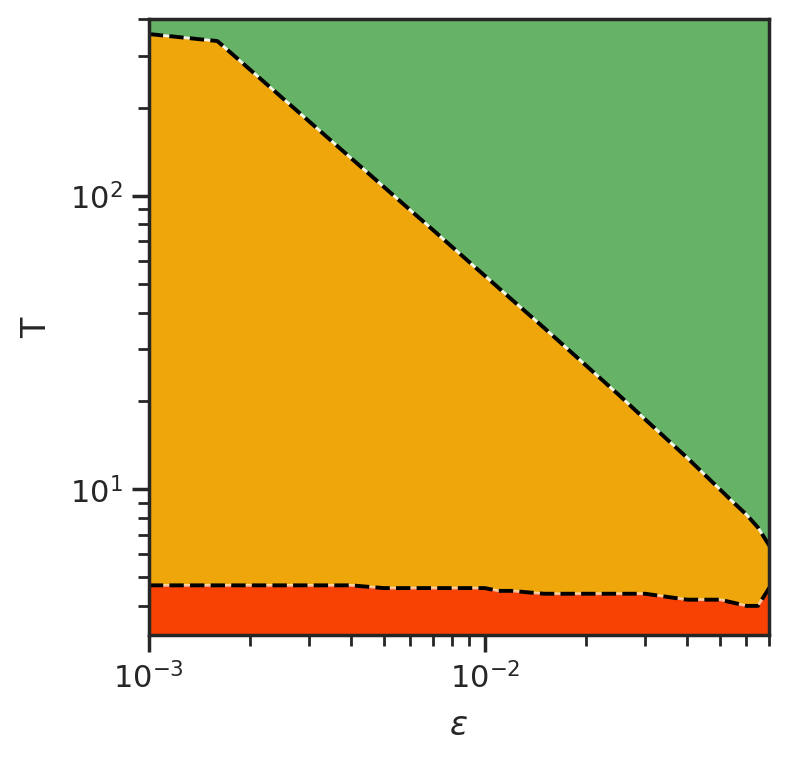

In [28]:
###Data
eps=r"$\epsilon$"
L_clus=np.array([356.1, 337.0,317.1,299.5,283.8,269.4,256.6,244.9,234.2,179.4,134.4,107.4,89.4,76.60000000000001,66.9,59.400000000000006,53.400000000000006, 48.5,44.4,35.5,21.0,17.3,12.8,10.0,9.0,8.2,7.4,5.7])
L_phase=np.array([4.7,4.7,4.7,4.7,4.7,4.7,4.7,4.7,4.7,4.7,4.7,4.6000000000000005,4.6000000000000005,4.6000000000000005,4.6000000000000005,4.6000000000000005,4.6000000000000005,4.5,4.5,4.4,4.4,4.4,4.2,4.2,4.1000000000000005,4.0,4.0,5.2])
epsilon=np.array([0.001,0.0016,0.0017,0.0018,0.0019,0.002,0.0021,0.0022,0.0023,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010,0.011,0.012,0.015,0.025,0.030,0.040,0.05,0.055,0.060,0.065,0.075])
y=400*np.ones_like(len(epsilon))
z=-3*np.log(epsilon)+340
###Figure
sns.set_theme(font_scale=1, style="ticks")
fig = plt.figure(figsize=[4,4],dpi=200)
plt.plot(epsilon,L_clus,"--", label='Time cluster',color='black',linewidth=1.4)
plt.plot(epsilon,L_phase,"--",label='Time bifurcation',color='black',linewidth=1.4)
plt.xscale('log')
plt.xlabel(eps,labelpad=5)
plt.yscale('log')
plt.ylabel('T',labelpad=6)
plt.fill_between(epsilon,y,facecolor='green',alpha=0.6)
plt.fill_between(epsilon,L_clus, facecolor='orange',alpha=0.9)
plt.fill_between(epsilon,L_phase,facecolor='red',alpha=0.6)

plt.ylim([0,400])
plt.xlim([0.001,0.07])
#ax.axis('tight')
#plt.tight_layout()
filename = "decai.png"
plt.savefig(filename)
plt.show()